In [3]:
from typing import Optional, Literal
from typing_extensions import TypedDict
from pydantic import BaseModel

from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command

from IPython.display import Image, display

- `TripIO` = input/output schema; `TripScratch` = intermediate scratch schema with extra fields.
- `plan()` takes a `TripIO` state and returns fixed scratch data (`answer`, `notes`, `score`).
- `compose()` takes that scratch state and returns a final `TripIO` with a fixed itinerary.
- The LangGraph pipeline is linear: START → plan → compose → END.
- `appA.invoke(...)` runs both nodes in order; actual input is ignored because both functions return hard-coded values.
- The diagram render simply visualizes this 2-step flow.


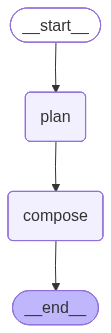

{'request': 'NYC 2-day plan for family of 4', 'answer': 'Day 1: Central Park → AMNH → Rockefeller; Day 2: Statue ferry → SoHo → Top of the Rock.'}


In [4]:


class TripIO(TypedDict):
    request: str
    answer: str

class TripScratch(TypedDict):
    request: str
    answer: str
    notes: str    
    score: float  

def plan(state: TripIO) -> TripScratch:
    
    return {
        "answer": "Drafting a Midtown-centric 2-day plan with indoor backups.",
        "notes": "family=4; hotel=Times Sq; budget=mid; indoors=rain",
        "score": 0.62,
    }

def compose(state: TripScratch) -> TripIO:
    
    return {
        "answer": "Day 1: Central Park → AMNH → Rockefeller; Day 2: Statue ferry → SoHo → Top of the Rock."
    }

gA = StateGraph(TripIO)
gA.add_node("plan", plan)
gA.add_node("compose", compose)
gA.add_edge(START, "plan")
gA.add_edge("plan", "compose")
gA.add_edge("compose", END)
appA = gA.compile()
display(Image(appA.get_graph().draw_mermaid_png()))

print(appA.invoke({"request": "NYC 2-day plan for family of 4"}))


- `TripFrame` defines a single unified state (request, answer, notes) used by all nodes.
- `brainstorm()` updates the state with fixed notes and a rough draft answer.
- `finalize()` overwrites the answer with a polished 2-day itinerary.
- The graph is a simple linear flow: START → brainstorm → finalize → END.
- Invoking the graph runs both steps in sequence; the actual request text is unused because both functions return hard-coded values.


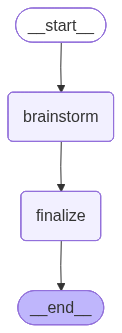

{'request': 'NYC family itinerary', 'answer': 'Day 1: Central Park → AMNH → Rockefeller; Day 2: Statue ferry → SoHo → skyline view.', 'notes': 'Prefer Midtown base; kid-friendly museum; indoor rainy day plan'}


In [5]:

class TripFrame(TypedDict):
    request: str
    answer: str
    notes: str

def brainstorm(state: TripFrame):
    return {
        "notes": "Prefer Midtown base; kid-friendly museum; indoor rainy day plan",
        "answer": "Sketching options near Central Park & Rockefeller."
    }

def finalize(state: TripFrame):    
    return {
        "answer": "Day 1: Central Park → AMNH → Rockefeller; Day 2: Statue ferry → SoHo → skyline view."
    }

gB = StateGraph(TripFrame)
gB.add_node("brainstorm", brainstorm)
gB.add_node("finalize", finalize)
gB.add_edge(START, "brainstorm")
gB.add_edge("brainstorm", "finalize")
gB.add_edge("finalize", END)
appB = gB.compile()
display(Image(appB.get_graph().draw_mermaid_png()))

print(appB.invoke({"request": "NYC family itinerary"}))

- `TripInput` and `TripOutput` are Pydantic models defining the graph’s typed input and final typed output.
- `TripWS` is the working state (TypedDict) that holds all intermediate fields.
- `sketch()` converts typed input into a richer working state with itinerary, score, and rain backup.
- `publish()` converts the working state into the final `TripOutput`.
- The graph specifies an input schema, a working state schema, and an output schema, with a linear flow: START → sketch → publish → END.
- Invoking the graph validates the input with Pydantic, executes both nodes, and returns a typed `TripOutput`.


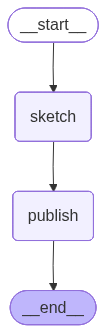

{'itinerary': 'Midtown plan focused on Central Park, AMNH, and Rockefeller. Add Statue ferry and SoHo for shopping on Day 2.'}

In [6]:

class TripInput(BaseModel):
    party_size: int
    neighborhood: Literal["Midtown","Downtown","Uptown"]
    days: int

class TripOutput(BaseModel):
    itinerary: str

class TripWS(TypedDict):
    party_size: int
    neighborhood: str
    days: int
    itinerary: str
    score: float
    rain_backup: bool

def sketch(state: TripInput) -> TripWS:
    base = "Midtown plan focused on Central Park, AMNH, and Rockefeller."
    return {
        "party_size": state.party_size,
        "neighborhood": state.neighborhood,
        "days": state.days,
        "itinerary": f"{base} Add Statue ferry and SoHo for shopping on Day 2.",
        "score": 0.71,
        "rain_backup": True,
    }

def publish(state: TripWS) -> TripOutput:
    return TripOutput(itinerary=state["itinerary"])

gC = StateGraph(
    TripWS,
    input_schema=TripInput,
    output_schema=TripOutput
)
gC.add_node("sketch", sketch)
gC.add_node("publish", publish)
gC.add_edge(START, "sketch")
gC.add_edge("sketch", "publish")
gC.add_edge("publish", END)
appC = gC.compile()
display(Image(appC.get_graph().draw_mermaid_png()))
appC.invoke({"party_size": 4, "neighborhood": "Midtown", "days": 2})

- `TripInput` and `TripOutput` are typed Pydantic models defining validated input and the final structured result (itinerary + human decision).
- `TripWS` is the working state that stores itinerary details plus extra fields needed for human-in-the-loop (HITL) review (`decision`, `edits`).
- `sketch()` turns validated input into a richer working state with a prebuilt itinerary, score, and rain plan.
- `review()`:
  - Prints a message prompting the human to approve or edit the itinerary.
  - Calls `interrupt(...)`, which **pauses the graph** until resumed with `Command(resume=...)`.
  - On resume, normalizes the user’s decision and applies edits if provided.
- `publish()` returns a final `TripOutput` combining the itinerary and the human’s decision state.
- The graph flow is linear with a human pause in the middle: START → sketch → review (interrupt) → publish → END.
- `MemorySaver` is required so the graph can pause and later resume from the same checkpoint during the HITL step.


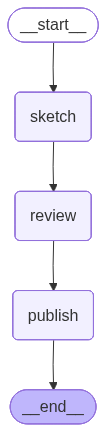

In [8]:
class TripInput(BaseModel):
    party_size: int
    neighborhood: Literal["Midtown","Downtown","Uptown"]
    days: int

class TripOutput(BaseModel):
    itinerary: str
    decision: Literal["approve","edit"]
    edits: Optional[str] = None

class TripWS(TypedDict, total=False):
    party_size: int
    neighborhood: str
    days: int
    itinerary: str
    score: float
    rain_backup: bool
    # HITL capture fields:
    decision: Literal["approve","edit"]
    edits: Optional[str]

def sketch(state: TripInput) -> TripWS:
    base = "Midtown plan focused on Central Park, AMNH, and Rockefeller."
    return {
        "party_size": state.party_size,
        "neighborhood": state.neighborhood,
        "days": state.days,
        "itinerary": f"{base} Add Statue ferry and SoHo for shopping on Day 2.",
        "score": 0.71,
        "rain_backup": True,
    }            

def review(state: TripWS) -> TripWS:
    # Build a readable payload for the human (shows up in notebook output)
    payload = {
        "message": "Review itinerary and approve or provide edits.",
        "proposal": state["itinerary"],
        "how_to_resume": (
            "Use Command(resume={'decision':'approve'}) OR "
            "Command(resume={'decision':'edit','edits':'<new text>'})"
        )
    }
    import json, sys
    print("\n=== HUMAN REVIEW REQUIRED ===", file=sys.stdout)
    print(json.dumps(payload, indent=2), file=sys.stdout)

    # Pause the graph until we resume with Command(resume=...)
    human = interrupt(payload)  # returns dict on resume

    # Normalize decision input
    decision = str(human.get("decision", "")).strip().lower()
    if decision not in ("approve", "edit"):
        # default to approve if empty/invalid
        decision = "approve"

    updates: TripWS = {"decision": decision}

    # Apply edit if requested and provided
    if decision == "edit":
        edits = (human.get("edits") or "").strip()
        if edits:
            updates["edits"] = edits
            updates["itinerary"] = edits  # <-- update itinerary
        else:
            # edit chosen but no text; keep original itinerary, still record choice
            updates["edits"] = None

    return updates

def publish(state: TripWS) -> TripOutput:
    # Return the final itinerary + what the human chose (captured in state)
    return TripOutput(
        itinerary=state["itinerary"],
        decision=state.get("decision", "approve"),
        edits=state.get("edits")
    )

# Wire the graph
gC = StateGraph(TripWS, input_schema=TripInput, output_schema=TripOutput)
gC.add_node("sketch", sketch)
gC.add_node("review", review)
gC.add_node("publish", publish)
gC.add_edge(START, "sketch")
gC.add_edge("sketch", "review")
gC.add_edge("review", "publish")
gC.add_edge("publish", END)

# Checkpointer is required for interrupts (pause/resume)
memory = MemorySaver()
appC = gC.compile(checkpointer=memory)

display(Image(appC.get_graph().draw_mermaid_png()))


- Invoking the graph with `configA` starts a run tied to a specific `thread_id`.
- Execution reaches the `review` node and **pauses** at the `interrupt`, printing the itinerary for human approval.
- This sets up the approve-flow where the user will later resume with a simple `decision="approve"`.


In [9]:
# Scenario A — Approve flow (no edits)

# 1) First invoke → graph pauses in 'review' and prints the proposal
configA = {"configurable": {"thread_id": "trip-demo-approve"}}
_ = appC.invoke(TripInput(party_size=3, neighborhood="Midtown", days=2), config=configA)


=== HUMAN REVIEW REQUIRED ===
{
  "message": "Review itinerary and approve or provide edits.",
  "proposal": "Midtown plan focused on Central Park, AMNH, and Rockefeller. Add Statue ferry and SoHo for shopping on Day 2.",
  "how_to_resume": "Use Command(resume={'decision':'approve'}) OR Command(resume={'decision':'edit','edits':'<new text>'})"
}


- `Command(resume={"decision": "approve"})` resumes the paused graph and completes the `review` node.
- The graph continues to `publish`, producing the final `TripOutput`.
- The code then extracts itinerary, decision, and edits (handling dict or model output).
- Result: human approved, no edits applied, final itinerary printed.


In [10]:


# 2) Human approves (resume with Command)
cmdA = Command(resume={"decision": "approve"})
finalA = appC.invoke(cmdA, config=configA)

# Defensive access (dict or TripOutput depending on version)
itineraryA = finalA["itinerary"] if isinstance(finalA, dict) else finalA.itinerary
decisionA  = finalA["decision"]   if isinstance(finalA, dict) else finalA.decision
editsA     = finalA.get("edits")  if isinstance(finalA, dict) else finalA.edits

print("\n=== SCENARIO A — APPROVE ===")
print("Decision:", decisionA)
print("Edits:", editsA)
print("Final Itinerary:", itineraryA)



=== HUMAN REVIEW REQUIRED ===
{
  "message": "Review itinerary and approve or provide edits.",
  "proposal": "Midtown plan focused on Central Park, AMNH, and Rockefeller. Add Statue ferry and SoHo for shopping on Day 2.",
  "how_to_resume": "Use Command(resume={'decision':'approve'}) OR Command(resume={'decision':'edit','edits':'<new text>'})"
}

=== SCENARIO A — APPROVE ===
Decision: approve
Edits: None
Final Itinerary: Midtown plan focused on Central Park, AMNH, and Rockefeller. Add Statue ferry and SoHo for shopping on Day 2.


- Starts Scenario B using a new `thread_id` to track this separate run.
- Invoking the graph pauses at the `review` node (interrupt) and prints the itinerary for human edits.
- This sets up the edit-flow, where the next step will resume with new itinerary text.

In [11]:
# Scenario B — Edit flow (apply changes)

# 1) First invoke → pauses in 'review'
configB = {"configurable": {"thread_id": "trip-demo-edit"}}
_ = appC.invoke(TripInput(party_size=4, neighborhood="Midtown", days=3), config=configB)


=== HUMAN REVIEW REQUIRED ===
{
  "message": "Review itinerary and approve or provide edits.",
  "proposal": "Midtown plan focused on Central Park, AMNH, and Rockefeller. Add Statue ferry and SoHo for shopping on Day 2.",
  "how_to_resume": "Use Command(resume={'decision':'approve'}) OR Command(resume={'decision':'edit','edits':'<new text>'})"
}


- Human resumes the paused graph with `decision="edit"` and a full replacement itinerary.
- The `review` node applies the edits, updating the working state.
- Execution moves to `publish`, returning the edited itinerary in the final output.
- The code extracts fields and prints the human-modified plan.


In [12]:

# 2) Human edits (resume with new text)
edited_text = (
    "Day 1: AMNH, Central Park (Belvedere + Bow Bridge), late lunch near CP.\n"
    "Day 2: SoHo shopping, Statue ferry in late afternoon, dinner in FiDi.\n"
    "Day 3: Rockefeller Center + Top of the Rock, Bryant Park stroll."
)
cmdB = Command(resume={"decision": "edit", "edits": edited_text})
finalB = appC.invoke(cmdB, config=configB)

# Defensive access
itineraryB = finalB["itinerary"] if isinstance(finalB, dict) else finalB.itinerary
decisionB  = finalB["decision"]   if isinstance(finalB, dict) else finalB.decision
editsB     = finalB.get("edits")  if isinstance(finalB, dict) else finalB.edits

print("\n=== SCENARIO B — EDIT ===")
print("Decision:", decisionB)
print("Edits present?:", bool(editsB))
print("Final Itinerary:\n", itineraryB)



=== HUMAN REVIEW REQUIRED ===
{
  "message": "Review itinerary and approve or provide edits.",
  "proposal": "Midtown plan focused on Central Park, AMNH, and Rockefeller. Add Statue ferry and SoHo for shopping on Day 2.",
  "how_to_resume": "Use Command(resume={'decision':'approve'}) OR Command(resume={'decision':'edit','edits':'<new text>'})"
}

=== SCENARIO B — EDIT ===
Decision: edit
Edits present?: True
Final Itinerary:
 Day 1: AMNH, Central Park (Belvedere + Bow Bridge), late lunch near CP.
Day 2: SoHo shopping, Statue ferry in late afternoon, dinner in FiDi.
Day 3: Rockefeller Center + Top of the Rock, Bryant Park stroll.
